Dataset photocatalyse – aperçu :
   pH  C0_mgL  masse_catalyseur_gL  temps_min type_lumiere  \
0   7      10                  0.4        120  LED visible   
1   7      10                  1.0         60      Visible   
2   7      10                  0.1        120           UV   
3   7      10                  0.5         60       UV-LED   
4   7      10                  0.5        120           UV   

          type_catalyseur  degradation_%                         reference  
0  TiO2/mRH-SNP rice husk             90        10.1007/s13201-023-02052-8  
1             NiO/Ag/TiO2             85          10.1021/acsomega.3c01766  
2                TiO2 P25             80  10.1016/j.jphotochem.2022.114527  
3                TiO2 P25             95                 10.1021/ie9012437  
4                 Ti-10Cr             70         10.1016/j.cej.2009.04.799  

Dimensions : (174, 8)

Corrélation rapide avec la dégradation :
degradation_%          1.000000
masse_catalyseur_gL    0.273979
pH 

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



Meilleurs paramètres du modèle ANN :
{'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__solver': 'adam'}
Coefficient de détermination R² = 0.720


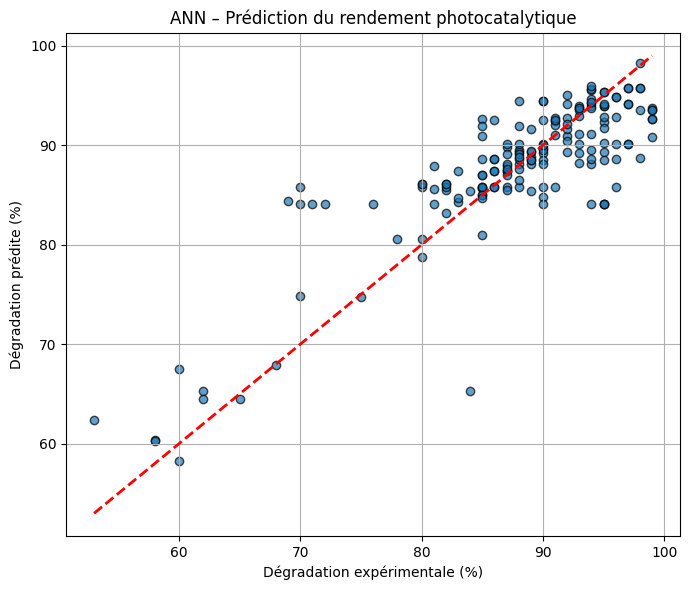

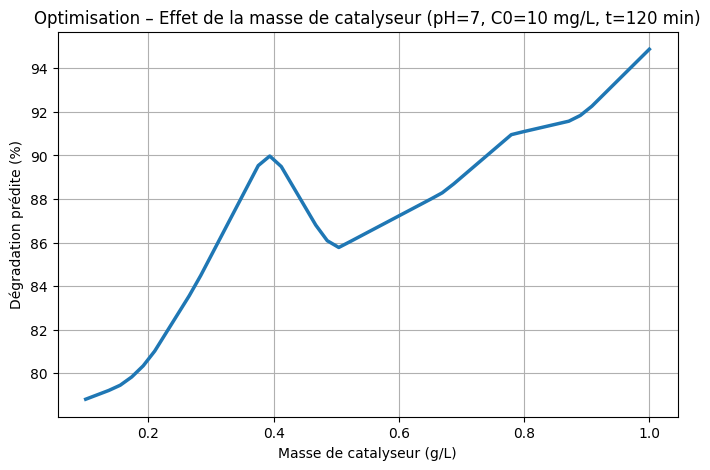

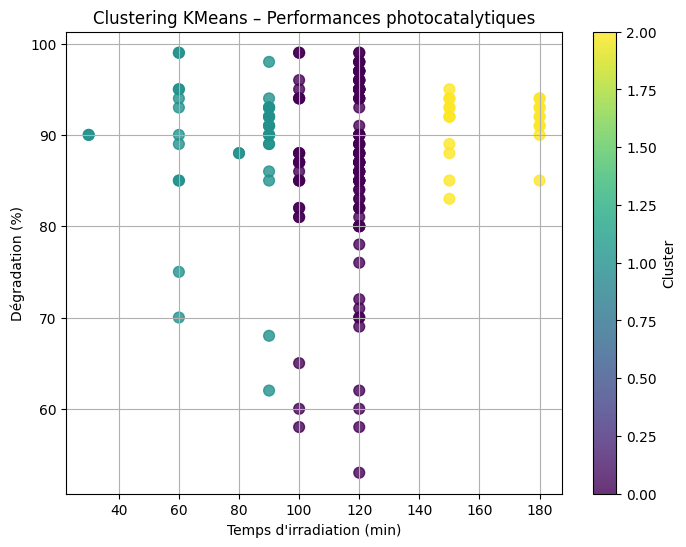


Résumé par cluster :
         degradation_%  temps_min  masse_catalyseur_gL    pH
Cluster                                                     
0                86.79     115.69                 0.43  5.66
1                88.72      76.11                 0.54  6.11
2                91.14     163.64                 0.44  6.73


In [3]:
# =====================================================
# 1. Libraries
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score

# =====================================================
# 2. Chargement du dataset photocatalyse
# =====================================================
# Remplace cette partie par ton propre chemin si tu exécutes localement
# Pour l'exemple on suppose que le fichier est chargé comme DataFrame df

# Exemple si tu lis depuis un fichier :
df = pd.read_csv("donnees_photocatalyse(1).csv")

# Ici on suppose que df existe déjà avec les colonnes attendues

# Nettoyage léger (au cas où)
df = df.dropna()  # au cas où il y aurait des lignes incomplètes

print("Dataset photocatalyse – aperçu :")
print(df.head())
print("\nDimensions :", df.shape)

# =====================================================
# 3. Séparation Inputs / Output
# =====================================================
# Variables quantitatives les plus influentes + faciles à modéliser
features = ["pH", "C0_mgL", "masse_catalyseur_gL", "temps_min"]
X = df[features].copy()
y = df["degradation_%"]

print("\nCorrélation rapide avec la dégradation :")
print(pd.concat([X, y], axis=1).corr()["degradation_%"].sort_values(ascending=False))

# =====================================================
# 4. Deep Learning Model (ANN + Optimisation)
# =====================================================
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(max_iter=10000, random_state=42, tol=1e-4))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (50,50), (100,50)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__solver": ["lbfgs", "adam"],
    "mlp__alpha": [0.0001, 0.001]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,               # plus robuste que cv=3 avec ~174 points
    scoring="r2",
    n_jobs=-1
)

print("\nEntraînement du modèle ANN (peut prendre quelques secondes)...")
grid.fit(X, y)

best_model = grid.best_estimator_

# =====================================================
# 5. Performance du modèle
# =====================================================
y_pred = best_model.predict(X)
r2 = r2_score(y, y_pred)

print("\nMeilleurs paramètres du modèle ANN :")
print(grid.best_params_)
print(f"Coefficient de détermination R² = {r2:.3f}")

# Scatter plot
plt.figure(figsize=(7,6))
plt.scatter(y, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Dégradation expérimentale (%)")
plt.ylabel("Dégradation prédite (%)")
plt.title("ANN – Prédiction du rendement photocatalytique")
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# 6. Simulation / Optimisation numérique
# =====================================================
# Exemple : effet de la masse de catalyseur à pH=7, C0=10 mg/L, t=120 min
simu = pd.DataFrame({
    "pH":               np.full(50, 7.0),
    "C0_mgL":           np.full(50, 10.0),
    "masse_catalyseur_gL": np.linspace(0.1, 1.0, 50),
    "temps_min":        np.full(50, 120.0)
})

simu["Predicted_degradation_%"] = best_model.predict(simu)

plt.figure(figsize=(8,5))
plt.plot(simu["masse_catalyseur_gL"], simu["Predicted_degradation_%"], linewidth=2.5)
plt.xlabel("Masse de catalyseur (g/L)")
plt.ylabel("Dégradation prédite (%)")
plt.title("Optimisation – Effet de la masse de catalyseur (pH=7, C0=10 mg/L, t=120 min)")
plt.grid(True)
plt.show()

# =====================================================
# 7. Clustering (groupes de performances)
# =====================================================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(
    df[["degradation_%", "temps_min", "masse_catalyseur_gL"]]
)

# Visualisation
plt.figure(figsize=(8,6))
scatter = plt.scatter(df["temps_min"], df["degradation_%"],
                      c=df["Cluster"], cmap="viridis", alpha=0.8, s=60)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("Temps d'irradiation (min)")
plt.ylabel("Dégradation (%)")
plt.title("Clustering KMeans – Performances photocatalytiques")
plt.grid(True)
plt.show()

# Résumé par cluster
print("\nRésumé par cluster :")
print(df.groupby("Cluster")[["degradation_%", "temps_min", "masse_catalyseur_gL", "pH"]].mean().round(2))

Meilleurs paramètres : {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (80,)}
R² (train) = 0.336


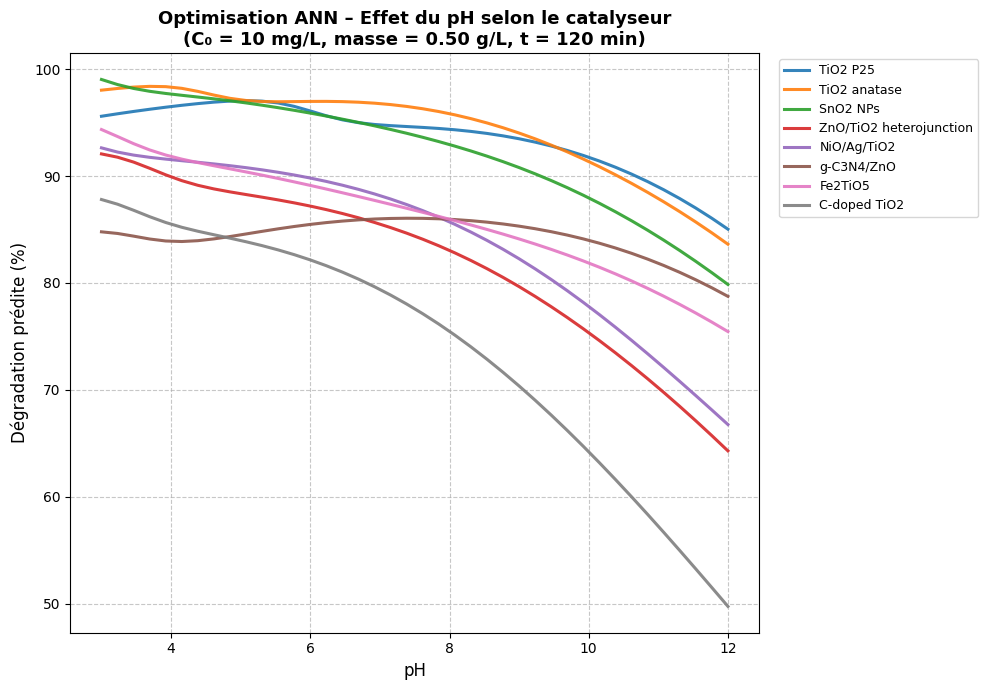

In [4]:
# =====================================================
# Optimisation numérique ANN : effet du pH et du type_catalyseur
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# 1. On suppose que df est déjà chargé
# df = pd.read_csv("donnees_photocatalyse(1).csv")

# On garde seulement les lignes complètes
df = df.dropna(subset=['pH', 'type_catalyseur', 'degradation_%', 'masse_catalyseur_gL', 'temps_min', 'C0_mgL'])

# Variables d'entrée
X = df[['pH', 'type_catalyseur', 'masse_catalyseur_gL', 'temps_min', 'C0_mgL']]
y = df['degradation_%']

# 2. Préprocesseur : standardisation + one-hot sur type_catalyseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['pH', 'masse_catalyseur_gL', 'temps_min', 'C0_mgL']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['type_catalyseur'])
    ])

# 3. Pipeline complet
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(max_iter=15000, random_state=42, tol=1e-4))
])

# 4. Recherche d'hyperparamètres (rapide)
param_grid = {
    'mlp__hidden_layer_sizes': [(80,), (120,), (80,40)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X, y)

print("Meilleurs paramètres :", grid.best_params_)
print(f"R² (train) = {grid.best_score_:.3f}")

best_model = grid.best_estimator_

# ────────────────────────────────────────────────
# 5. OPTIMISATION NUMÉRIQUE : pH + type_catalyseur
# ────────────────────────────────────────────────

# Conditions fixes (moyennes ou typiques)
masse_fix = df['masse_catalyseur_gL'].median()      # ≈ 0.4–0.5
temps_fix  = 120
C0_fix     = 10

# Catalyseurs les plus fréquents (tu peux modifier cette liste)
catalyseurs_interet = [
    'TiO2 P25', 'TiO2 anatase', 'SnO2 NPs', 'ZnO/TiO2 heterojunction',
    'NiO/Ag/TiO2', 'g-C3N4/ZnO', 'Fe2TiO5', 'C-doped TiO2'
]

# Grille de pH
pH_values = np.linspace(3, 12, 40)   # de très acide à très basique

plt.figure(figsize=(10, 7))

for cat in catalyseurs_interet:
    if cat not in df['type_catalyseur'].unique():
        continue

    # Création de la grille de simulation
    simu = pd.DataFrame({
        'pH': pH_values,
        'type_catalyseur': [cat] * len(pH_values),
        'masse_catalyseur_gL': [masse_fix] * len(pH_values),
        'temps_min': [temps_fix] * len(pH_values),
        'C0_mgL': [C0_fix] * len(pH_values)
    })

    pred = best_model.predict(simu)

    plt.plot(simu['pH'], pred, label=cat, linewidth=2.2, alpha=0.9)

plt.xlabel("pH", fontsize=12)
plt.ylabel("Dégradation prédite (%)", fontsize=12)
plt.title(f"Optimisation ANN – Effet du pH selon le catalyseur\n"
          f"(C₀ = {C0_fix} mg/L, masse = {masse_fix:.2f} g/L, t = {temps_fix} min)",
          fontsize=13, fontweight='bold')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()